In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from helper_functions.flow_data_discretization import *

data = pd.read_pickle('./data/scenario_10.pkl')
data.head()

data_nobground = data[data['Label']!='Background']

infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

test_hosts = np.append(infected_hosts[1:], normal_hosts[1:])
test_hosts = shuffle(test_hosts)
test_hosts

array(['147.32.84.209', '147.32.84.192', '147.32.84.205', '147.32.87.11',
       '147.32.84.204', '147.32.84.206', '147.32.80.9', '147.32.84.134',
       '147.32.84.193', '147.32.84.164', '147.32.84.207', '147.32.87.36',
       '147.32.84.191', '147.32.84.208'], dtype='<U13')

In [2]:
# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}

char_cols = ['Prot']

for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize(data_nobground[c])

# Uncomment this line, if you want to see the mapppings for the conversion
# label_mapping

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [3]:
ranks = 2

packets = data_nobground['Packets'].values
data_nobground['Disc_Packets'] = discretize_ordinal(packets, ranks)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [4]:
def extract_ngrams(data, n):
    l = len(data)
    if l%n==0:
        ngrams = np.reshape(data, [l//n, n])
    else:
        ngrams = np.reshape(data[:-(l%n)], [(l-l%n)//n, n])
        
    return ngrams

In [5]:
import itertools

def laplace_smoothing(unique_ngrams, ngrams_counts, max_unigram):
    
#     unigrams = np.unique(unique_ngrams)
    unigrams = np.arange(max_unigram+1)
#     print(unigrams)
    n = unique_ngrams.shape[1]
    
    comb = list(itertools.product(unigrams, repeat=n))

    smoothed_ngrams = list(unique_ngrams)
    smoothed_count = list(ngrams_counts)
    for ngram in comb:
        exists = np.sum(np.prod(np.equal(ngram, unique_ngrams), axis=1))
        
        if exists==0:
#             print(ngram, exists)
            smoothed_ngrams.append(ngram)
            smoothed_count.append(1)
    smoothed_ngrams = np.array(smoothed_ngrams)
    smoothed_count = np.array(smoothed_count)
    
    return smoothed_ngrams, smoothed_count

In [27]:
prob = np.zeros(len(trigrams))
i = 0
for ii in trigrams:
    b_ind = np.where(np.prod(np.equal(ii[:-1], unique_bigrams), axis=1))
    t_ind = np.where(np.prod(np.equal(ii, unique_trigrams), axis=1))
#     print("Trigram: ", ii)
#     print("Unique Trigram: ", unique_trigrams[t_ind])
#     print("Unique Bigrams: ", unique_bigrams[b_ind], "\n")
    prob[i] = trigrams_counts[t_ind]/bigrams_counts[b_ind]
    
    i=i+1
    

In [9]:
counts = data_clean.groupby(by='Src_IP_Addr').size()
counts.sort_values(ascending=False).head(10)

Src_IP_Addr
147.32.96.69     100394
147.32.84.59      90560
147.32.80.13      36949
147.32.84.205     24572
147.32.84.206     23169
147.32.84.208     22844
147.32.84.204     22804
147.32.84.207     21861
147.32.84.191     21494
147.32.84.192     21473
dtype: int64

In [6]:
import operator

def extract_profile(ngrams, ngrams_counts):
    
    ngrams = ngrams.astype(str)
    string_cat = lambda x: ''.join(x)
    ngrams = np.apply_along_axis(string_cat, 1, ngrams)
    
    prof = dict(zip(ngrams, ngrams_counts))
    prof_norm = dict(zip(ngrams, ngrams_counts/sum(ngrams_counts)))
    
    sorted_count = sorted(prof_norm.items(), key=operator.itemgetter(0))
    
    return prof, prof_norm, np.array(sorted_count)

# prof, prof_norm, sorted_count = extract_profile(smoothed_infected_ngrams, smoothed_infected_counts)
# sorted_count[]

In [7]:
n = 2 
feat = ['Prot', 'Disc_Packets']
use_smoothing = False

# Extracting the infected training profile
infected_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == infected_hosts[0], data_nobground['Dst_IP_Addr']==infected_hosts[0])]
infected_data = infected_data[feat].values

infected_code, _ = extract_code(infected_data)
infected_ngrams = extract_ngrams(infected_code, n)
unique_infected_ngrams, unique_infected_counts = np.unique(infected_ngrams, axis=0, return_counts=True)
if use_smoothing:
    max_unigram = np.max(unique_infected_ngrams)
    smoothed_infected_ngrams, smoothed_infected_counts = laplace_smoothing(unique_infected_ngrams, unique_infected_counts, max_unigram)
    _, infected_prof, infected_sorted_prof = extract_profile(smoothed_infected_ngrams, smoothed_infected_counts)
else:
    _, infected_prof, infected_sorted_prof = extract_profile(unique_infected_ngrams, unique_infected_counts)

# Extracting the normal profile
normal_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == normal_hosts[0], data_nobground['Dst_IP_Addr']==normal_hosts[0])]
normal_data = normal_data[feat].values

normal_code, _ = extract_code(normal_data)
normal_ngrams = extract_ngrams(normal_code, n)
unique_normal_ngrams, unique_normal_counts = np.unique(normal_ngrams, axis=0, return_counts=True)
if use_smoothing:
    smoothed_normal_ngrams, smoothed_normal_counts = laplace_smoothing(unique_normal_ngrams, unique_normal_counts, max_unigram)
    _, normal_prof, normal_sorted_prof = extract_profile(smoothed_normal_ngrams, smoothed_normal_counts)
else:
    _, normal_prof, normal_sorted_prof = extract_profile(unique_normal_ngrams, unique_normal_counts)

Text(0, 0.5, 'Extracted code')

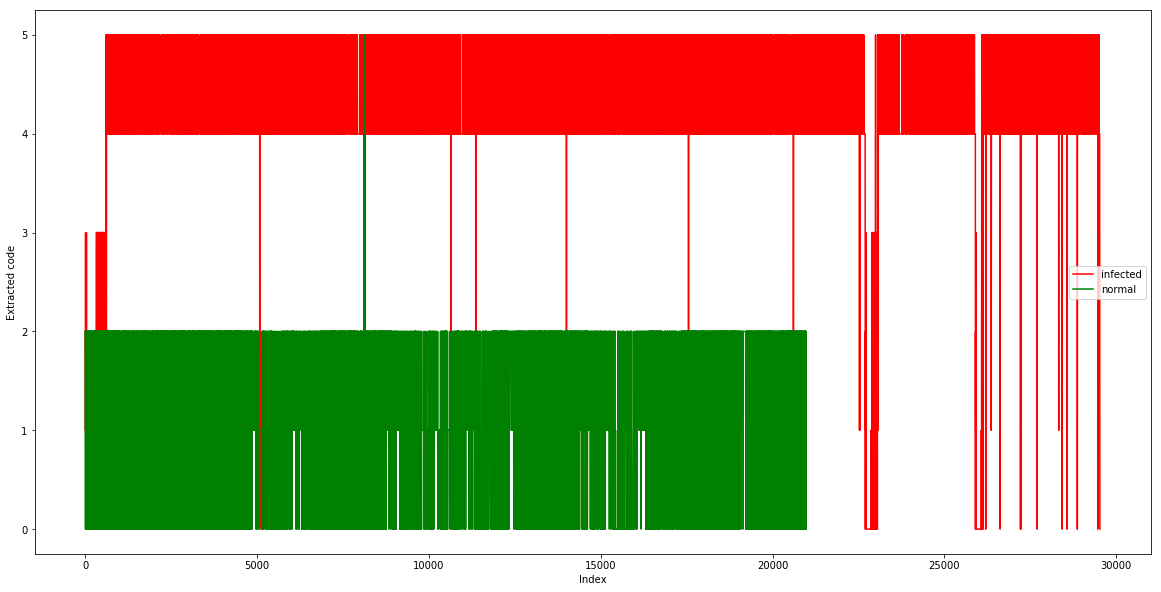

In [17]:
plt.figure(figsize=(20,10))
plt.plot(infected_code, color='r', label='infected')
plt.plot(normal_code, color='g', label='normal')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Extracted code")

In [33]:
def distance(sorted_prof, host_prof):
    
    dist = 0
    for i in range(len(sorted_prof)):
        ngram, f = sorted_prof[i]
#         print(ngram, f)
        if ngram not in host_prof.keys():
            continue
#         print(f-host_prof[ngram])
        dist += ((f-host_prof[ngram]) / ((f+host_prof[ngram])/2))**2
    return dist

In [9]:
def distance(train_prof, host_prof, sorted_train_prof, sorted_host_prof, N):
    
    if N>=len(sorted_train_prof):
        train_ngrams = sorted_train_prof[:, 0]
    else:
        train_ngrams = sorted_train_prof[:N, 0]
    
    if N>=len(sorted_host_prof):
        host_ngrams = sorted_host_prof[:, 0]
    else:
        host_ngrams = sorted_host_prof[:N, 0]
    
    ngrams = np.append(train_ngrams, host_ngrams)
    ngrams = np.unique(ngrams)
    
    dist = 0
    for ngram in ngrams:
        if ngram not in train_prof.keys():
            f_train = 0
        else:
            f_train = train_prof[ngram]

        if ngram not in host_prof.keys():
            f_host = 0
        else:
            f_host = host_prof[ngram]
        dist += ((f_train-f_host) / ((f_train+f_host)/2))**2
    return dist

In [20]:
# def distance(unique_host_ngrams, prof_ngrams, host_prob, prof_prob):
    
#     distance,i = 0,0
#     for ngram in unique_host_ngrams:
#         ind = np.where(np.prod(np.equal(ngram, prof_ngrams), axis=1))
#         print(ind)
#         distance = distance + ((prof_prob[ind] - host_prob[i]) / ((prof_prob[ind] - host_prob[i])/2))**2 
# #         print(distance)
#         i = i+1
        
#     return distance

In [20]:
pred = np.zeros(len(test_hosts), dtype=int)
i=0
for host in test_hosts:
    host_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == host, data_nobground['Dst_IP_Addr']==host)]
    if len(host_data)<n:
        i = i+1
        continue
    host_data = host_data[feat].values
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, n)
    unique_host_ngrams, unique_host_counts = np.unique(host_ngrams, axis=0, return_counts=True)
    if use_smoothing:
        smoothed_host_ngrams, smoothed_host_counts = laplace_smoothing(unique_host_ngrams, unique_host_counts, max_unigram)
        _, host_prof, sorted_host_prof = extract_profile(smoothed_host_ngrams, smoothed_host_counts)
    else:
        _, host_prof, sorted_host_prof = extract_profile(unique_host_ngrams, unique_host_counts)
    
    normal_distance = distance(normal_prof, host_prof, normal_sorted_prof, sorted_host_prof, 2)
    infected_distance = distance(infected_prof, host_prof, infected_sorted_prof, sorted_host_prof, 2)
    
#     print(host, normal_distance, infected_distance)
    if infected_distance < normal_distance:
        
        pred[i] = 1

    i = i+1

In [19]:
TP = np.sum(np.isin(test_hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(test_hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  9
FP:  1
FN:  0
TN: 4
14


In [67]:
n = 5

infected_ngrams = extract_ngrams(infected_code, n)
unique_infected_ngrams, unique_infected_counts = np.unique(infected_ngrams, axis=0, return_counts=True)
infected_prob = unique_host_counts/sum(unique_infected_counts)
smoothed_ngrams, smoothed_count = laplace_smoothing(unique_infected_ngrams, unique_infected_counts)

hosts = np.unique(data_clean['Src_IP_Addr'].values)
ordinal_val = [1]
feat = ['Prot', 'Packets']

pred = np.zeros(len(hosts), dtype=int)
i=0
for host in hosts:
    host_data = data_clean[data_clean['Src_IP_Addr']==host]
    if len(host_data)<n:
        continue
    host_data = host_data[feat].values
    host_data[:,1] = discretize_ordinal(host_data[:,1], ordinal_val)
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, n)
    host_unique_ngrams, host_count = np.unique(host_ngrams, axis=0, return_counts=True)
    host_prob = host_count/np.sum(host_count)
    host_alarms = host_prob < min(infected_prob)
    
    if np.sum(host_alarms)>0:
        pred[i]=1
    
    i = i+1

KeyboardInterrupt: 

In [305]:
TP = np.sum(np.isin(hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  0
FP:  11
FN:  9
TN: 501
521


In [155]:
n = 5

infected_ngrams = extract_ngrams(infected_code, n)
unique_infected_ngrams, unique_infected_counts = np.unique(infected_ngrams, axis=0, return_counts=True)
smoothed_ngrams, smoothed_count = laplace_smoothing(unique_infected_ngrams, unique_infected_counts)

hosts = np.unique(data_clean['Src_IP_Addr'].values)
ordinal_val = [1]
feat = ['Prot', 'Packets']

pred = np.zeros(len(hosts), dtype=int)
i=0
for host in hosts:
    host_data = data_clean[data_clean['Src_IP_Addr']==host]
    if len(host_data)<n:
        continue
    host_data = host_data[feat].values
    host_data[:,1] = discretize_ordinal(host_data[:,1], ordinal_val)
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, n)
    host_unique_ngrams, host_count = np.unique(host_ngrams, axis=0, return_counts=True)
    host_prob = host_count/np.sum(host_count)
#     print("Prob: ", host_prob, "\n")
    host_alarms = host_prob < (min(smoothed_count[smoothed_count>1])/sum(smoothed_count[smoothed_count>1]))

    if np.sum(host_alarms)>0:
#         print("Alarm: ",     host_prob, "\n")
        pred[i]=1
    
    i = i+1

In [149]:
TP = np.sum(np.isin(hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  0
FP:  13
FN:  9
TN: 499
521


## HMMs

In [36]:
from hmmlearn.hmm import GaussianHMM

hmm = GaussianHMM(n_components=2)
hmm.fit(trigrams)
log_likelihood = hmm.decode(trigrams)[0]
ll = hmm.score(trigrams)
print(log_likelihood, ll)

-17324.66024185303 -17323.728556142418


In [37]:
num_states = np.arange(2,10)
ll = []
for n in num_states:
    hmm = GaussianHMM(n_components=n)
    hmm.fit(trigrams)
#     ll.append(hmm.decode(trigrams)[0])
    ll.append(hmm.score(trigrams))

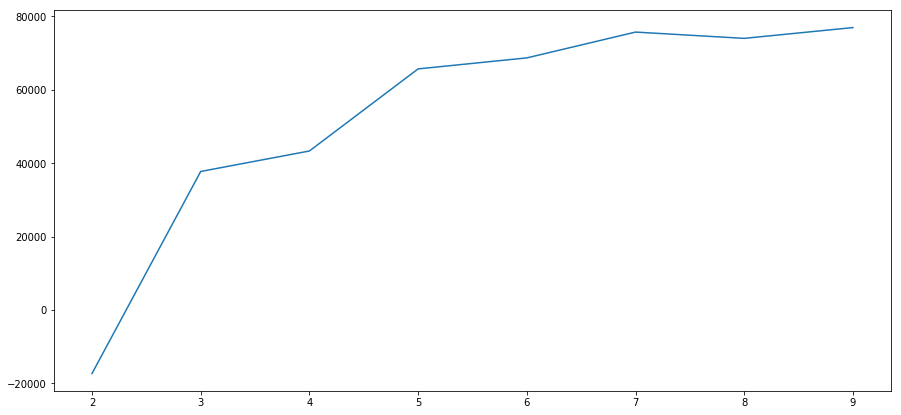

In [39]:
plt.figure(figsize=(15,7))
plt.plot(num_states, ll)

In [99]:
train_ind = []
test_ind = []

indices_even = list(range(0, len(trigrams), 2))
indices_odd = list(range(1, len(trigrams), 2))
train_ind.append(indices_even)
train_ind.append(indices_odd)
test_ind.append(indices_odd)
test_ind.append(indices_even)

num_states = np.arange(2,16)
num_iter = 5

mean = []
std = []
mean_ll = []
std_ll = []
for n in num_states:
    for it in range(num_iter):
        ll = []
        for i in range(2):
            hmm = GaussianHMM(n_components=n)
            hmm.fit(trigrams[train_ind[i]])
            ll.append(hmm.score(trigrams[test_ind[i]]))
        mean.append(np.mean(ll))
        std.append(np.std(ll))
    mean_ll.append(np.mean(mean))
    std_ll.append(np.std(std))
mean_ll = np.array(mean_ll)
std_ll = np.array(std_ll)

Text(0, 0.5, 'Log-likelihood')

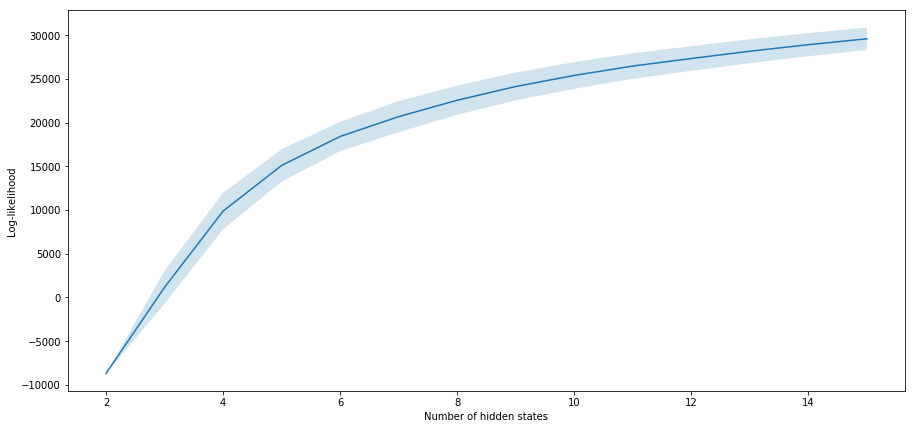

In [100]:
plt.figure(figsize=(15,7))
plt.plot(num_states, mean_ll)
plt.fill_between(num_states, mean_ll-std_ll, mean_ll+std_ll, alpha=0.2)
plt.xlabel("Number of hidden states")
plt.ylabel("Log-likelihood")

In [95]:
l = []
hmm = GaussianHMM(n_components=3)
for i in range(10):
    hmm.fit(trigrams[train_ind[0]])
    l.append(hmm.score(trigrams[test_ind[1]]))
l


[7021.903097915728,
 7022.0462841625085,
 7022.046283415905,
 7022.046283415905,
 7022.04628894302,
 7022.0462841625085,
 17239.95994969656,
 7022.046283415905,
 7022.046283415905,
 7022.04628894302]

In [116]:
hosts = np.unique(data_clean['Src_IP_Addr'].values)
ordinal_val = [1]
feat = ['Prot', 'Packets']
n = 10
num_states = 4
num_iter = 5

infected_ngrams = extract_ngrams(infected_code, n)

hmm = GaussianHMM(num_states)
ll = []
for it in range(num_iter):
    hmm.fit(infected_ngrams)
    ll.append(hmm.score(infected_ngrams))
log_likelihood = np.mean(ll)

pred = np.zeros(len(hosts), dtype=int)
log_l = np.zeros(len(hosts))
i=0
for host in hosts:
    host_data = data_clean[data_clean['Src_IP_Addr']==host]
    if len(host_data)<n:
        continue
    host_data = host_data[feat].values
    host_data[:,1] = discretize_ordinal(host_data[:,1], ordinal_val)
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, n)
    
    ll = []
    for it in range(num_iter):
        ll.append(hmm.score(host_ngrams))
    log_l[i] = np.mean(ll)
    
    i = i+1

In [117]:
pred = abs(log_l - log_likelihood) <= abs(log_likelihood/2)

TP = np.sum(np.isin(hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  1
FP:  32
FN:  8
TN: 480
521


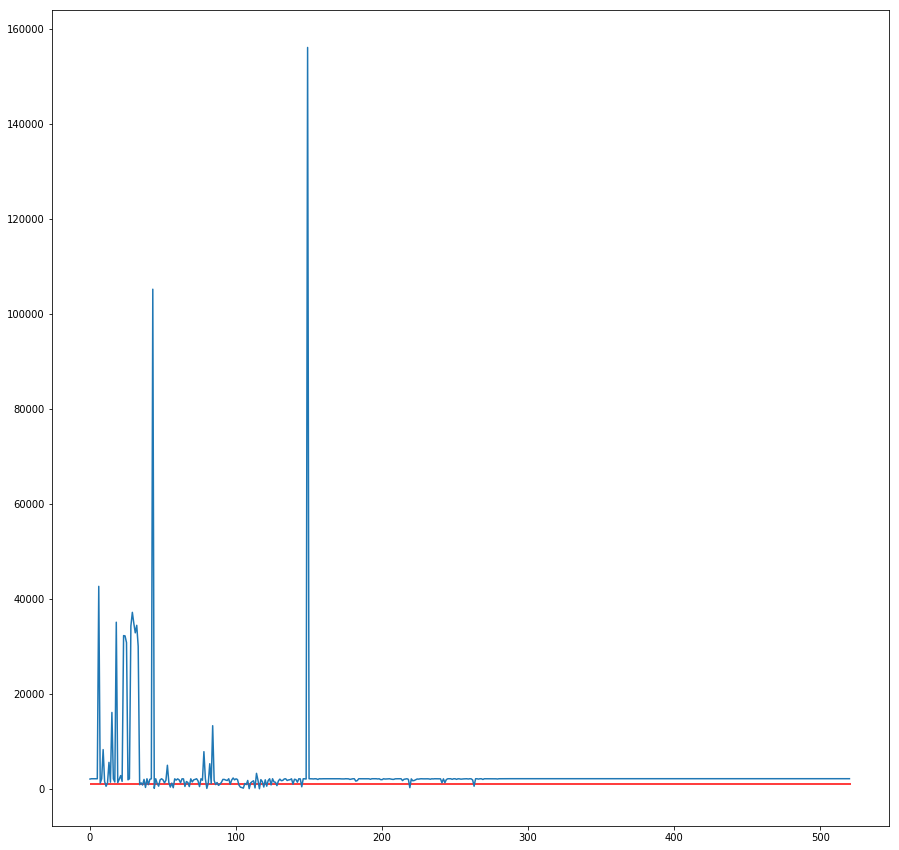

In [127]:
plt.figure(figsize=(15,15))
plt.plot(abs(log_l-log_likelihood))
plt.hlines(y=abs(log_likelihood)/2,xmin=0, xmax=len(log_l), color='r')

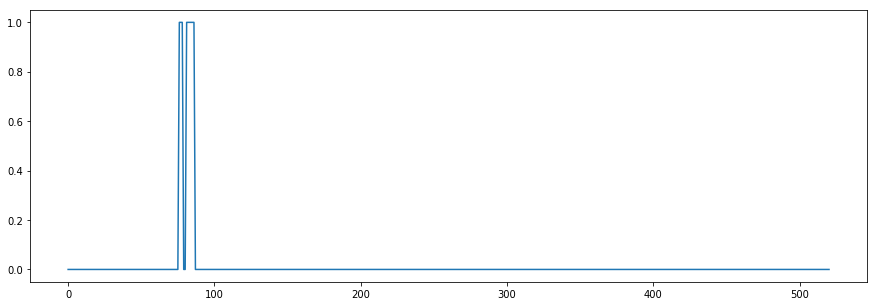

In [145]:
plt.figure(figsize=(15,5))
t = np.isin(hosts, infected_hosts).astype(int)
plt.plot(range(len(t)), t)

In [142]:
t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,